In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
from shapely.geometry import Polygon, MultiPolygon, box
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox 
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch, Circle
import matplotlib.ticker as mticker
import sklearn
import importlib
import cartopy.crs as ccrs
import cartopy as ctp

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_plotting = os.path.join(folder_HMA, 'Plotting')

# open rgi
path_rgi = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_full_rgi.shp")
path_dc = os.path.join(folder_HMA, 'Datasets', "AOI definition", "Final AOI", "final Products", "AOI_dc_rgi.shp")
rgi_gdf = gpd.read_file(path_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(path_rgi).to_crs("ESRI:102025")

# open the subregion df
path_o1 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o1regions.shp")
path_o2 = os.path.join(folder_HMA, 'Datasets', "RGI", "RGI2000-v7.0-regions", "RGI2000-v7.0-o2regions.shp")
o1_gdf = gpd.read_file(path_o1).to_crs("ESRI:102025")
o2_gdf_all = gpd.read_file(path_o2).to_crs("ESRI:102025")

# subset to the HMA regions
o1_gdf = o1_gdf[o1_gdf['o1region'].isin(["13","14","15"])]
o2_gdf = o2_gdf_all[o2_gdf_all['o2region'].isin(rgi_gdf['o2region'])].copy() # only get o2regions with our glaciers

In [3]:
# add color column to o2_gdf, based on o1region
colors = []
for idx,row in o2_gdf.iterrows():
    if row['o1region']=='13': colors.append('red')
    elif row['o1region']=='14': colors.append('blue')
    elif row['o1region']=='15': colors.append('yellow')
o2_gdf['colors']=colors

In [4]:
# opening a Natural Earth background
path_background = os.path.join(folder_plotting, 'NE1_HR_LC', "NE1_HR_LC_projected.tif")
background_im = riox.open_rasterio(path_background)

# clip to main extent
xlims = (-2500000, 1000000)
ylims = (-700000, 2000000)
background_im = background_im.sel(x=slice(xlims[0]-2000,xlims[1]+2000), y=slice(ylims[1]+2000, ylims[0]-2000))

In [5]:
# open rivers and lakes and countries etc
path_rivers = os.path.join(folder_plotting, 'ne_10m_rivers_lake_centerlines', "ne_10m_rivers_lake_centerlines.shp")
path_lakes = os.path.join(folder_plotting, 'ne_10m_lakes', "ne_10m_lakes.shp")
path_countries = os.path.join(folder_plotting, 'ne_10m_admin_0_boundary_lines_land', "ne_10m_admin_0_boundary_lines_land.shp")
path_cities = os.path.join(folder_plotting, "ne_10m_populated_places_simple", "ne_10m_populated_places_simple.shp")
rivers_gdf = gpd.read_file(path_rivers).to_crs("ESRI:102025")
lakes_gdf = gpd.read_file(path_lakes).to_crs("ESRI:102025")
countries_gdf = gpd.read_file(path_countries).to_crs("ESRI:102025")
cities_gdf = gpd.read_file(path_cities).to_crs("ESRI:102025")

In [6]:
big_cities = ["Kathmandu", "Lhasa", "Thimphu", "New Delhi", 'Islamabad', 'Almaty', 'Kashgar']
big_cities_gdf = cities_gdf[cities_gdf['name'].isin(big_cities)]

In [7]:
# define esri:102025 projection for cartopy
projection = ccrs.AlbersEqualArea(central_longitude=95.0, central_latitude=30,
                            false_easting=0.0, false_northing=0.0,
                            standard_parallels=(15.0, 65.0), globe=None)

# other matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

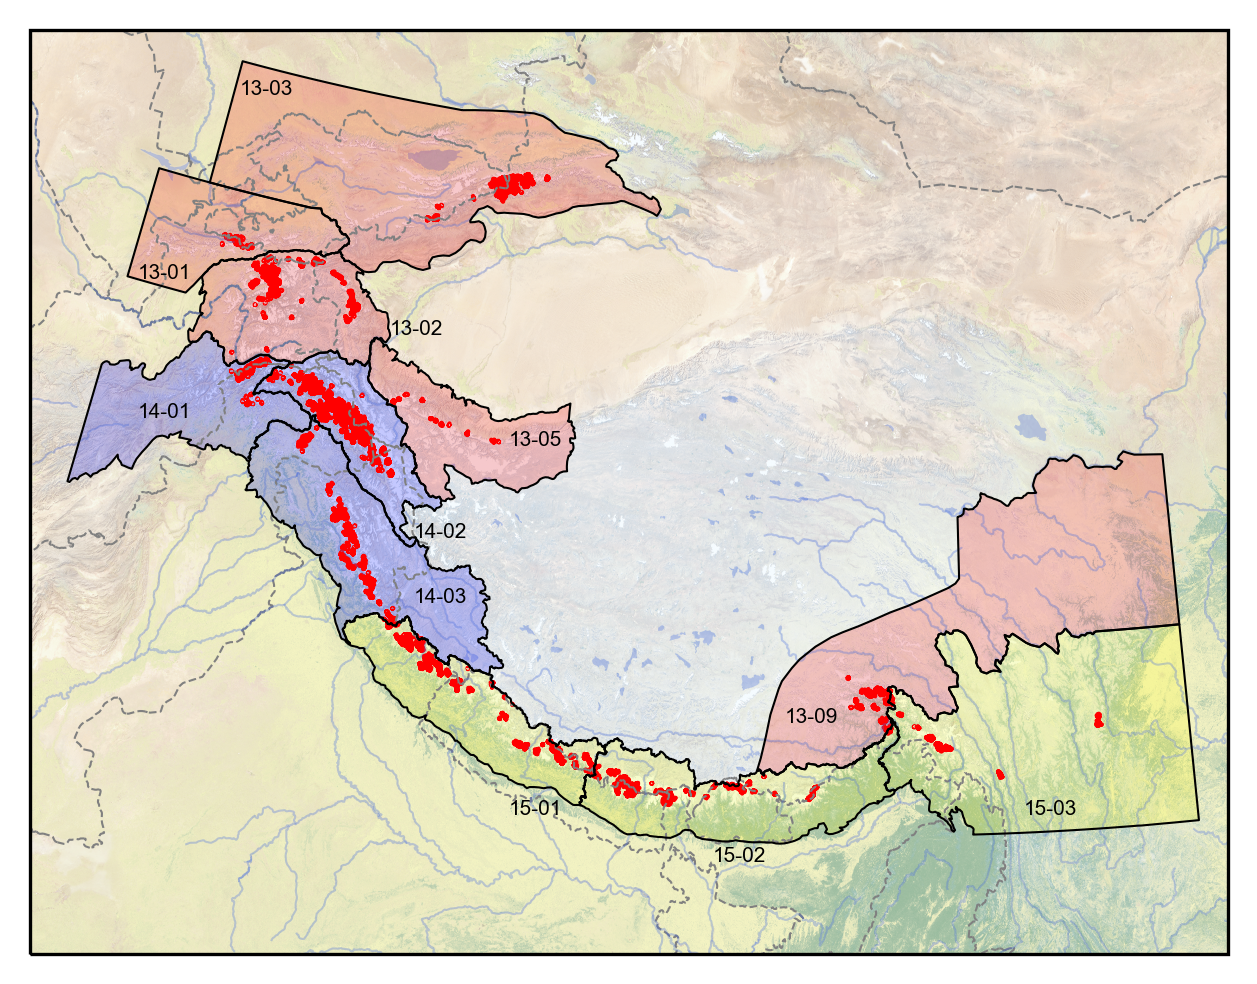

In [51]:
# initiate figure
fig,axs = plt.subplots(figsize=(6.5,4), dpi=300, subplot_kw={'projection': projection})

# background image
background_im.plot.imshow(rgb='band', ax=axs)

# countries
countries_gdf.plot(ax=axs, edgecolor='gray', linestyle='dashed', facecolor='none', linewidth=0.5)

# cities
# big_cities_gdf.plot(ax=axs, color='black', markersize=2)

# rivers and lakes
watercolor = 'royalblue'
rivers_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3)
lakes_gdf.plot(ax=axs, color=watercolor, linewidth=0.5, alpha=0.3)

# o2region boundaries, adding colors along the way
o2_gdf.boundary.plot(ax=axs, edgecolor='black', facecolor='none', linewidth=0.5)
o2_gdf.plot(ax=axs, edgecolor='none', color=o2_gdf['colors'], alpha=0.2)
# o1_gdf.plot(ax=axs, edgecolor='black', facecolor='none')

# glaciers
rgi_gdf.plot(ax=axs, color='red', edgecolor='red', linewidth=1)

# # axis limits, etc
axs.set_xlim(xlims)
axs.set_ylim(ylims)
axs.set_title("")

# # add lat/lon gridlines
# gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, ypadding=3, xpadding=4,
#               linestyle=(5,(20,20)), linewidth=0.2, color='0', alpha=0.5)

# manually define text labels of regions
r_text = ['13-01', "13-02", '13-03','13-05','13-09',
               '14-01', "14-02", '14-03',
               '15-01', "15-02", '15-03']

r_locs = [[0.09,0.73], [0.3,0.67],  [0.175,0.93], [0.4,0.55], [0.63,0.25],
          [0.09,0.58], [0.32,0.45], [0.32,0.38],
          [0.4,0.15],  [0.57,0.1],  [0.83,0.15]]

# add text to label rgi subregions
label_size = 5
for i in range(len(region_text)):
    axs.text(r_locs[i][0], r_locs[i][1], r_text[i], transform=axs.transAxes, fontsize=label_size)

# gridline edits
gl.top_labels=False
gl.right_labels=False
gl.xlabel_style = {'size':6, 'rotation':'horizontal', 'ha':'center'}
gl.ylabel_style = {'size':6, 'rotation':'vertical', 'ha':'center'}
gl.xlocator = mticker.FixedLocator([70, 80, 90, 100])
gl.ylocator = mticker.FixedLocator([25, 30, 35, 40, 45])